# Metodi iterativi

### Caricamento matrici

In [24]:
import matplotlib.pyplot as plt
import scipy as sp
from matspy import spy
import numpy as np
import time

In [ ]:
spa1 = sp.io.mmread('./matrici/spa1.mtx').tocsr()
spa2 = sp.io.mmread('./matrici/spa2.mtx').tocsr()
vem1 = sp.io.mmread('./matrici/vem1.mtx').tocsr()
vem2 = sp.io.mmread('./matrici/vem2.mtx').tocsr()

spy(spa1, title='spa1', figsize=10, dpi=300)
spy(spa2, title='spa2', figsize=10, dpi=300)
spy(vem1, title='vem1', figsize=10, dpi=300)
spy(vem2, title='vem2', figsize=10, dpi=300)


In [22]:
# Creo il vettore b da x_test per spa1
x_test = np.ones(spa1.shape[0], dtype=np.float64)
b_spa1 = spa1.dot(x_test)

x0_spa1 = np.zeros(spa1.shape[0], dtype=np.float64)

# Creo il vettore b da x_test per spa2
x_test = np.ones(spa2.shape[0], dtype=np.float64)
b_spa2 = spa2.dot(x_test)

x0_spa2 = np.zeros(spa2.shape[0], dtype=np.float64)

# Creo il vettore b da x_test per vem1
x_test = np.ones(vem1.shape[0], dtype=np.float64)
b_vem1 = vem1.dot(x_test)

x0_vem1 = np.zeros(vem1.shape[0], dtype=np.float64)

# Creo il vettore b da x_test per vem2
x_test = np.ones(vem2.shape[0], dtype=np.float64)
b_vem2 = vem2.dot(x_test)

x0_vem2 = np.zeros(vem2.shape[0], dtype=np.float64)

## Metodo di Jacobi
Implementa il metodo di Jacobi per la risoluzione di sistemi lineari su matrici sparse.

Parametri:
    A (scipy.sparse.matrix): La matrice del sistema lineare.
    b (numpy.ndarray): Il vettore dei termini noti.
    x0 (numpy.ndarray): La soluzione iniziale.
    tol (float): La tolleranza per la convergenza.
    max_iter (int): Il numero massimo di iterazioni.

Restituisce:
    numpy.ndarray: La soluzione approssimativa del sistema lineare.


Convergenza a 4 iterazioni
Tempo spa1: 0.959583044052124

Convergenza a 3 iterazioni
Tempo spa2: 2.335949420928955

Convergenza a 378 iterazioni
Tempo vem1: 108.47734427452087

Convergenza a 527 iterazioni
Tempo vem2: 240.35818672180176



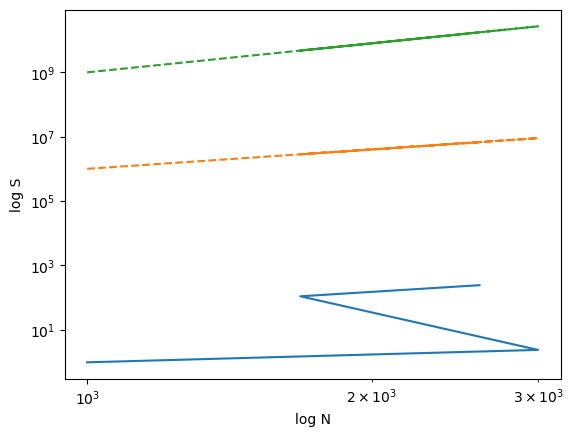

In [27]:
def jacobi(A, b, x0, tol, max_iter):
    # Dimensione del sistema
    n = A.shape[0]
    x = x0.copy()

    for it in range(max_iter):

        # Aggiornamento X
        for i in range(n):
            # Prendo il valore della diagonale
            d = A[i, i]
            r = b[i] - sum(A[i, :i] * x[:i]) - sum(A[i, i+1:] * x[i+1:])
            x[i] = r / d

        # Controlla la convergenza
        if (np.linalg.norm(A * x - b))/np.linalg.norm(b) < tol:
            print(f"Convergenza a {it} iterazioni")
            break

    return x

start = time.time()
jacobi(A=spa1, b=b_spa1, x0=x0_spa1, tol=10e-4, max_iter=20000)
end = time.time()
spa1_time = end-start
print(f"Tempo spa1: {spa1_time}\n")

start = time.time()
jacobi(A=spa2, b=b_spa2, x0=x0_spa2, tol=10e-4, max_iter=20000)
end = time.time()
spa2_time = end-start
print(f"Tempo spa2: {spa2_time}\n")

start = time.time()
jacobi(A=vem1, b=b_vem1, x0=x0_vem1, tol=10e-4, max_iter=20000)
end = time.time()
vem1_time = end-start
print(f"Tempo vem1: {vem1_time}\n")

start = time.time()
jacobi(A=vem2, b=b_vem2, x0=x0_vem2, tol=10e-4, max_iter=20000)
end = time.time()
vem2_time = end-start
print(f"Tempo vem2: {vem2_time}\n")

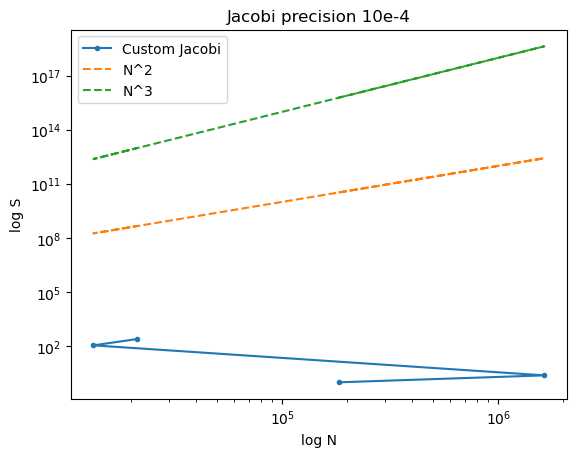

In [32]:
spa1_value = spa1.count_nonzero()
spa2_value = spa2.count_nonzero()
vem1_value = vem1.count_nonzero()
vem2_value = vem2.count_nonzero()

ypoint = np.array([spa1_time, spa2_time, vem1_time, vem2_time])
xpoint = np.array([spa1_value, spa2_value, vem1_value, vem2_value])

ypoint_quadratic = np.array([pow(spa1_value, 2), pow(spa2_value, 2), 
                             pow(vem1_value, 2), pow(vem2_value, 2)])
xpoint_quadratic = np.array([spa1_value, spa2_value, vem1_value, vem2_value])

ypoint_cubical = np.array([pow(spa1_value, 3), pow(spa2_value, 3), 
                           pow(vem1_value, 3), pow(vem2_value, 3)])
xpoint_cubical = np.array([spa1_value, spa2_value, vem1_value, vem2_value])

plt.xscale('log')
plt.yscale('log')
plt.xlabel('log N')
plt.ylabel('log S')
plt.plot(xpoint, ypoint, label="Custom Jacobi", marker='.')
plt.plot(xpoint_quadratic, ypoint_quadratic, label="N^2",linestyle="--")
plt.plot(xpoint_cubical, ypoint_cubical, label="N^3",linestyle="--")

plt.title(label="Jacobi precision 10e-4")
plt.legend()
plt.show()

## Metodo di Gauss-Seidel
    
Risolve un sistema lineare Ax = b usando il metodo di Gauss-Seidel.

Parametri:
    A: matrice dei coefficienti (matrice sparsa).
    b: vettore dei termini noti.
    x0: vettore di partenza (soluzione iniziale).
    tol: tolleranza di convergenza.
    max_iter: numero massimo di iterazioni.

Ritorna:
    x: vettore approssimato della soluzione.


In [33]:
def forward_substitution(L, b):
    n = L.shape[0]
    x = np.zeros(L.shape[0])

    if L[0, 0] == 0:
        return []
    
    x[0]=b[0]/L[0, 0]
    for i in range(1, n):
        if L[i, i] == 0:
            return []
        x[i] = (b[i] - (L[i, :]*x))/L[i, i]

    return x

def gauss_seidel(A, b, x0, tol, max_iter):
    # Dimensione del sistema
    x = x0.copy()

    P = sp.sparse.tril(A).tocsr()
    y = np.zeros(P.shape[0])  

    # Ciclo di iterazioni
    for it in range(max_iter):
        r = b - (A*x)

        # Sostituzione in avanti Py = r
        y = forward_substitution(L=P, b=r)

        x = x + y

        # Controllo della convergenza
        if  (np.linalg.norm(A*x - b))/np.linalg.norm(b) < tol:
            print(f"Convergenza a {it} iterazioni")
            break

    return x

start = time.time()
gauss_seidel(A=spa1, b=b_spa1, x0=x0_spa1, tol=10e-4, max_iter=20000)
end = time.time()
spa1_time = end-start
print(f"Tempo spa1: {spa1_time}\n")

start = time.time()
gauss_seidel(A=spa2, b=b_spa2, x0=x0_spa2, tol=10e-4, max_iter=20000)
end = time.time()
spa2_time = end-start
print(f"Tempo spa2: {spa2_time}\n")

start = time.time()
gauss_seidel(A=vem1, b=b_vem1, x0=x0_vem1, tol=10e-4, max_iter=20000)
end = time.time()
vem1_time = end-start
print(f"Tempo vem1: {vem1_time}\n")

start = time.time()
gauss_seidel(A=vem2, b=b_vem2, x0=x0_vem2, tol=10e-4, max_iter=20000)
end = time.time()
vem2_time = end-start
print(f"Tempo vem2: {vem2_time}\n")

Convergenza a 4 iterazioni
Tempo spa1: 0.9328150749206543

Convergenza a 3 iterazioni
Tempo spa2: 2.1419501304626465

Convergenza a 378 iterazioni
Tempo vem1: 81.02572631835938

Convergenza a 527 iterazioni
Tempo vem2: 176.8637251853943



## Metodo di discesa del gradiente
    
Risolve un sistema lineare Ax = b usando il metodo del Gradiente.

Parametri:
    A: matrice dei coefficienti (matrice sparsa).
    b: vettore dei termini noti.
    x0: vettore di partenza (soluzione iniziale).
    alpha: coefficiente di passo.
    tol: tolleranza di convergenza.
    max_iter: numero massimo di iterazioni.

Ritorna:
    x: vettore approssimato della soluzione.

In [ ]:
def metodo_gradiente(A, b, x0, tol, max_iter):
    # Dimensione del sistema
    x = x0.copy() 

    for it in range(max_iter):
        # Calcolo residuo
        r = b - (A*x)
        y = A*r

        rt = r.T
        a = rt @ r
        c = rt @ y
        x = x + ((a/c)*r)

        # Controllo della convergenza
        if (np.linalg.norm(A * x - b))/np.linalg.norm(b) < tol:
            print(f"Convergenza a {it} iterazioni")
            break

    return x

start = time.time()
metodo_gradiente(A=spa1, b=b_spa1, x0=x0_spa1, tol=10e-4, max_iter=20000)
end = time.time()
spa1_time = end-start
print(f"Tempo spa1: {spa1_time}\n")

start = time.time()
metodo_gradiente(A=spa2, b=b_spa2, x0=x0_spa2, tol=10e-4, max_iter=20000)
end = time.time()
spa2_time = end-start
print(f"Tempo spa2: {spa2_time}\n")

start = time.time()
metodo_gradiente(A=vem1, b=b_vem1, x0=x0_vem1, tol=10e-4, max_iter=20000)
end = time.time()
vem1_time = end-start
print(f"Tempo vem1: {vem1_time}\n")

start = time.time()
metodo_gradiente(A=vem2, b=b_vem2, x0=x0_vem2, tol=10e-4, max_iter=20000)
end = time.time()
vem2_time = end-start
print(f"Tempo vem2: {vem2_time}\n")

## Metodo di discesa del gradiente coniugato

Risolve un sistema lineare simmetrico e definito positivo Ax = b usando il metodo del Gradiente coniugato.

Parametri:
    A: matrice dei coefficienti (matrice sparsa simmetrica e definita positiva).
    b: vettore dei termini noti.
    x0: vettore di partenza (soluzione iniziale).
    tol: tolleranza di convergenza.
    max_iter: numero massimo di iterazioni.

Ritorna:
    x: vettore approssimato della soluzione.


In [ ]:
def metodo_gradiente_coniugato(A, b, x0, tol, max_iter):
    # Dimensione del sistema
    x = x0.copy()
    r = b - (A*x)
    d = r

    for it in range(max_iter):
        # Determino prossima soluzione
        r = b - (A*x)

        # Se non ho residuo sono già alla convergenza
        if r.all() == 0:
            print(f"Convergenza a {it} iterazioni")
            break

        y = A*d
        alpha = (d*r)/(d*y)
        x = x + (alpha*d)

        # Controllo della convergenza
        numerator = A*x

        if (sp.linalg.norm(numerator - b))/sp.linalg.norm(b) < tol:
            print(f"Convergenza a {it} iterazioni")
            break

        # Determino direzione prossimo passo
        r = b - (A*x)
        w = A*r
        beta = (d*w)/(d*y)
        d = r - (beta*d)        

    return x

start = time.time()
metodo_gradiente_coniugato(A=spa1, b=b_spa1, x0=x0_spa1, tol=10e-4, max_iter=20000)
end = time.time()
spa1_time = end-start
print(f"Tempo spa1: {spa1_time}\n")

start = time.time()
metodo_gradiente_coniugato(A=spa2, b=b_spa2, x0=x0_spa2, tol=10e-4, max_iter=20000)
end = time.time()
spa2_time = end-start
print(f"Tempo spa2: {spa2_time}\n")

start = time.time()
metodo_gradiente_coniugato(A=vem1, b=b_vem1, x0=x0_vem1, tol=10e-4, max_iter=20000)
end = time.time()
vem1_time = end-start
print(f"Tempo vem1: {vem1_time}\n")

start = time.time()
metodo_gradiente_coniugato(A=vem2, b=b_vem2, x0=x0_vem2, tol=10e-4, max_iter=20000)
end = time.time()
vem2_time = end-start
print(f"Tempo vem2: {vem2_time}\n")
